## Import Libraries 

In [1]:
import warnings
import sys
sys.path.insert(0, '../../src')
warnings.filterwarnings('ignore')

In [2]:
import ABC_train_test2
import friedman3Dataset
import network
import dataset
import sanityChecks
import torch 
import scrapbook as sb
from statistics import mean 
import catboost as ctb 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error
import numpy as np

## Parameters 

In [3]:
variance = 1
bias = 1 

In [4]:
# Parameters
variance = 0.01
bias = 0.01


## Dataset 


In [5]:
#Parameters 
n_features = 4
n_samples= 100
n_target = 1

In [6]:
X,Y = friedman3Dataset.friedman3_data(n_samples)

          X1           X2        X3        X4         Y
0  57.030151  1002.824867  0.628349  1.843507  1.426088
1  31.101296  1277.548610  0.012891  9.705435  0.438695
2  19.124820  1495.835863  0.925506  6.493822  1.650559
3  94.568359  1727.063673  0.558704  2.355801  1.420098
4  37.801609   921.221648  0.236753  1.148774  1.414015


In [7]:
#Train test split for dataset 
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.2)
train_data = dataset.CustomDataset(X_train,Y_train)
test_data = dataset.CustomDataset(X_test,Y_test)


## Training Parameters 

In [8]:
batch_size = 32
n_epochs = 1000
#Select the device 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ABC Pre-generator Model 

1. The catboost model is used as a pre-generator model for the ABC-GAN. 
2. The model is first trained on the entire dataset 
3. It generats X,Y pairs and we add some Gaussian noise with mean 0 and variance 1 to it which is then feed as input to the generator.


In [ ]:
#Train the Model 
prior_model = ctb.CatBoostRegressor()
prior_model.fit(X_train,Y_train)

In [10]:
y_pred = prior_model.predict(X_test)
y_abc = y_pred + np.random.normal(0,variance, y_pred.shape) + bias 
mse = mean_squared_error(y_pred,Y_test)
sb.glue("Prior Model MSE",mse)
mse = mean_squared_error(y_abc,Y_test)
sb.glue("ABC Pre-generator MSE",mse)
mae = mean_absolute_error(y_pred,Y_test)
sb.glue("Prior Model MAE",mae)
print("Prior Model MAE",mae)
mae = mean_absolute_error(y_abc,Y_test)
sb.glue("ABC Pre-generator MAE",mae)
print("ABC Pre-generator MAE",mae)

Prior Model MAE 0.36773983048580267


ABC Pre-generator MAE 0.3719729395572945


# mGAN Model

In [11]:
gen = network.Generator(n_features+1).to(device)
disc = network.Discriminator(n_features+1).to(device)

criterion = torch.nn.BCELoss()
gen_opt = torch.optim.Adam(gen.parameters(), lr=0.001, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc.parameters(), lr=0.001, betas=(0.5, 0.999))

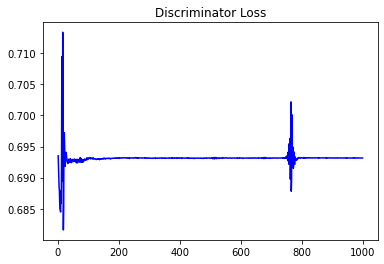

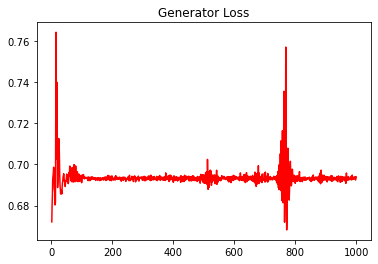

In [12]:
#Training the ABC_GAN 
ABC_train_test2.training_GAN(disc,gen,disc_opt,gen_opt,train_data,batch_size,n_epochs,criterion,prior_model,variance,bias,device)

In [13]:
ABC_GAN1_metrics=ABC_train_test2.test_generator(gen,test_data,prior_model,variance,bias,"1",device)
sb.glue("ABC_GAN_1 Metrics",ABC_GAN1_metrics)

print("MAE")
print(mean(ABC_GAN1_metrics[1]))

MAE
0.3607338563017547


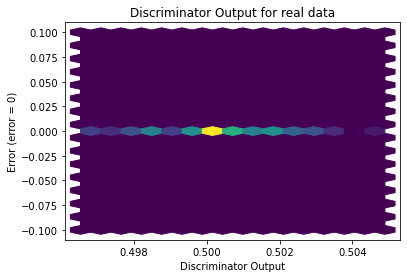

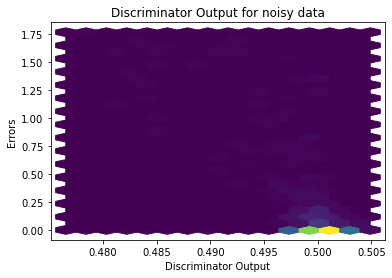

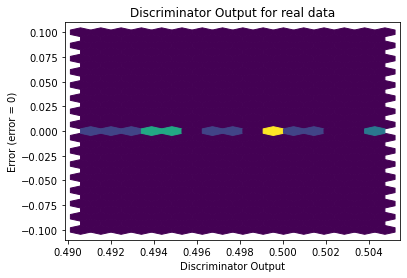

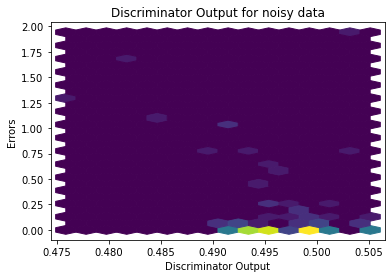

In [14]:
sanityChecks.discProbVsError(train_data,disc,device)
sanityChecks.discProbVsError(test_data,disc,device)

# mGAN Model with TabNet Generator

In [15]:
gen2 = network.GeneratorTabnet(n_features+1).to(device)
disc2 = network.Discriminator(n_features+1).to(device)

criterion = torch.nn.BCELoss()
gen_opt = torch.optim.Adam(gen2.parameters(), lr=0.001, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc2.parameters(), lr=0.001, betas=(0.5, 0.999))

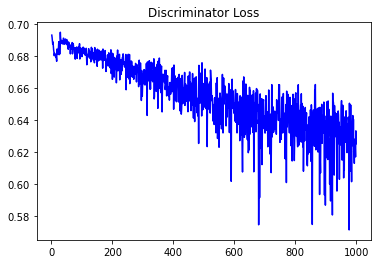

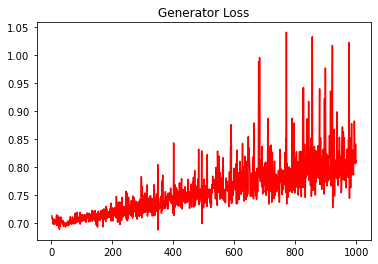

In [16]:
#Training the ABC_GAN 
ABC_train_test2.training_GAN(disc2,gen2,disc_opt,gen_opt,train_data,batch_size,n_epochs,criterion,prior_model,variance,bias,device)

In [17]:
ABC_GAN2_metrics=ABC_train_test2.test_generator(gen2,test_data,prior_model,variance,bias,"1",device)
sb.glue("ABC_GAN_2 Metrics",ABC_GAN2_metrics)

print("MAE")
print(mean(ABC_GAN2_metrics[1]))

MAE
0.38201695910468697


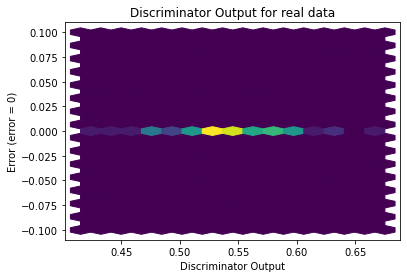

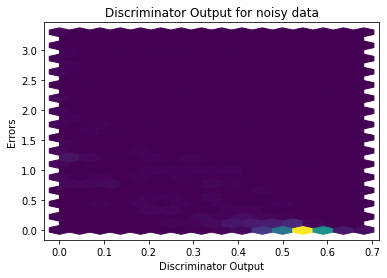

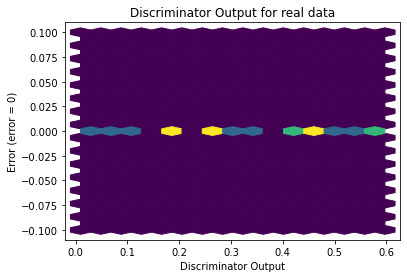

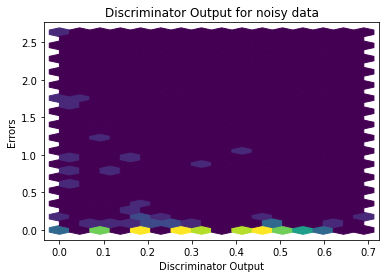

In [18]:
sanityChecks.discProbVsError(train_data,disc2,device)
sanityChecks.discProbVsError(test_data,disc2,device)

# skipGAN Model

In [19]:
#Generator
gen3 = network.GeneratorWithSkipConnection(n_features+1).to(device)
constraints=network.weightConstraint()
#Discriminator 
disc3 = network.Discriminator(n_features+1).to(device)

criterion = torch.nn.BCELoss()
gen_opt = torch.optim.Adam(gen3.parameters(), lr=0.001, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc3.parameters(), lr=0.001, betas=(0.5, 0.999))


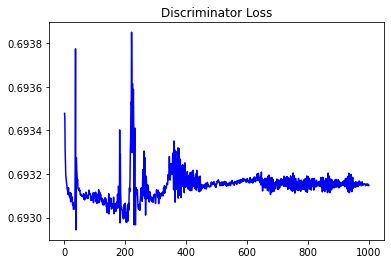

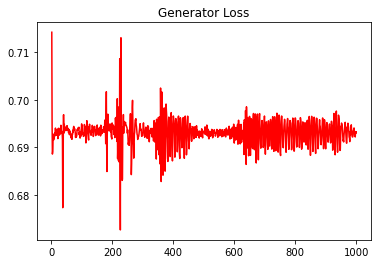

In [20]:
ABC_train_test2.training_GAN_skip_connection(disc3,gen3,disc_opt,gen_opt,train_data,batch_size,n_epochs,criterion,prior_model,variance,bias,device)

In [21]:
ABC_GAN3_metrics=ABC_train_test2.test_generator(gen3,test_data,prior_model,variance,bias,"3",device)
sb.glue("ABC_GAN_3 Metrics",ABC_GAN3_metrics)

print("MAE")
print(mean(ABC_GAN3_metrics[1]))

MAE
0.369349984806031


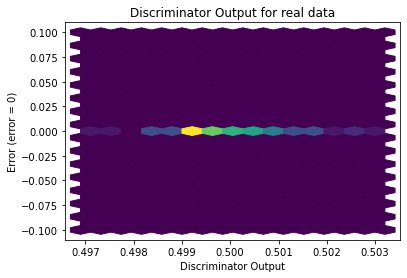

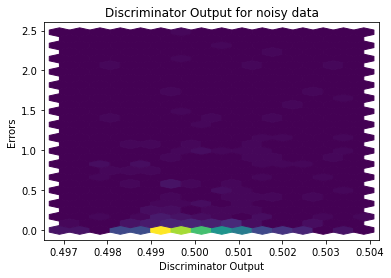

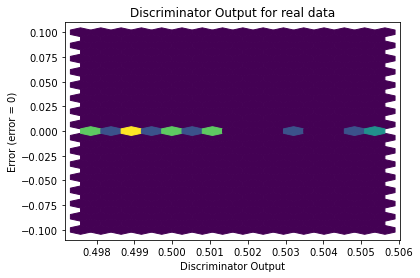

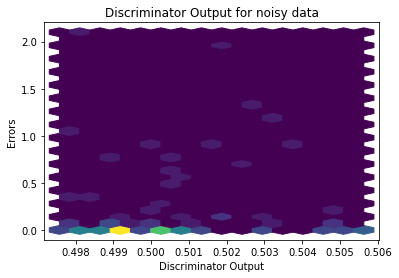

In [22]:
sanityChecks.discProbVsError(train_data,disc3,device)
sanityChecks.discProbVsError(test_data,disc3,device)

# skipGAN Model with TabNet Generator

In [23]:
#Generator
gen4 = network.GeneratorTabnetskipConnection(n_features+1).to(device)
constraints=network.weightConstraint()
#Discriminator 
disc4 = network.Discriminator(n_features+1).to(device)

criterion = torch.nn.BCELoss()
gen_opt = torch.optim.Adam(gen4.parameters(), lr=0.001, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc4.parameters(), lr=0.001, betas=(0.5, 0.999))


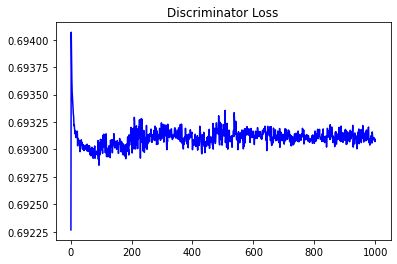

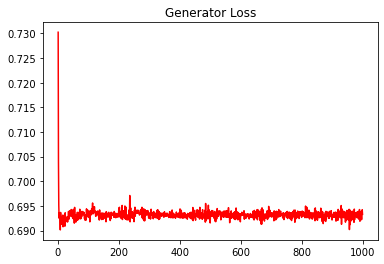

In [24]:
ABC_train_test2.training_GAN_skip_connection(disc4,gen4,disc_opt,gen_opt,train_data,batch_size,n_epochs,criterion,prior_model,variance,bias,device)

In [25]:
ABC_GAN4_metrics=ABC_train_test2.test_generator(gen4,test_data,prior_model,variance,bias,"3",device)
sb.glue("ABC_GAN_4 Metrics",ABC_GAN4_metrics)

print("MAE")
print(mean(ABC_GAN4_metrics[1]))

MAE
0.36188176420703533


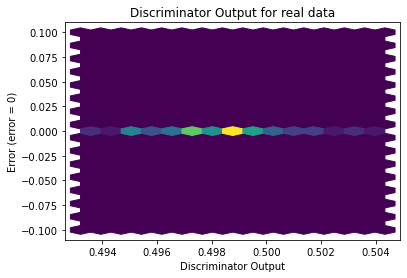

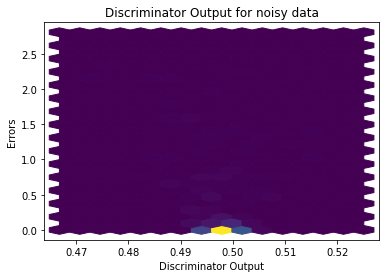

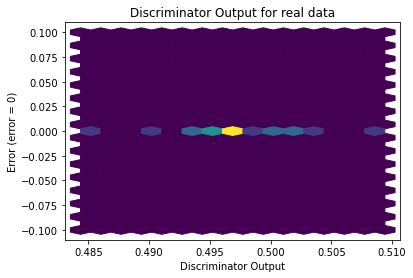

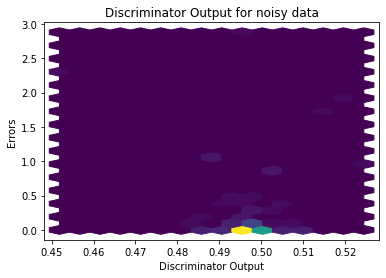

In [26]:
sanityChecks.discProbVsError(train_data,disc4,device)
sanityChecks.discProbVsError(test_data,disc4,device)

## Skip Connection Model Analysis - ABC-GAN 

### Weight Analysis 

Study the weights of the skip connection layer

Equation of the skip connection is 

$output = y_{gan} * w + y_{abc} * (1-w)$

In [27]:
print("Weight of the node at skip connection")
for name,param in gen3.named_parameters():
    if(name == "skipNode.weight"):
        print(param)
        sb.glue("Skip Connection Weight",param.item())

Weight of the node at skip connection
Parameter containing:
tensor([[0.0315]], requires_grad=True)


## skipGAN Model Analysis (TabNet Generator) 

### Weight Analysis 

Study the weights of the skip connection layer

Equation of the skip connection is 

$output = y_{gan} * w + y_{abc} * (1-w)$

In [28]:
print("Weight of the node at skip connection")
for name,param in gen4.named_parameters():
    if(name == "skipNode.weight"):
        print(param)
        sb.glue("Skip Connection Weight",param.item())

Weight of the node at skip connection
Parameter containing:
tensor([[0.0168]], requires_grad=True)
